```julia
using Pkg
Pkg.activate(".")
Pkg.add("IJulia Plots Printf Revise Statistics")
Pkg.dev("..")
```

In [1]:
# Error with scientific format in plot axes
ENV["GKS_ENCODING"] = "utf8"

using Plots
using Printf
using Statistics

# The default format SVG creates figures of size 9600x6400
gr(fmt="png")
nothing

In [2]:
using Revise

In [3]:
using ReinforcementLearningSutton.Commons: LearningSarsa, PlayerεGreedy, play_game
using ReinforcementLearningSutton.GridWorld: GameGridWorldBase, GameGridWorld

In [4]:
dims = (10, 7)
pos_start = (1, 4)
pos_goal = (8, 4)

allowed_movements_all = Dict(
    "cross"             => [( 1,  0), ( 0,  1), (-1,  0), ( 0, -1)],
    "queen"             => [( 1,  0), ( 1,  1), ( 0,  1), (-1,  1), (-1,  0), (-1, -1), ( 0, -1), ( 1, -1)],
    "queen_plus_freeze" => [( 1,  0), ( 1,  1), ( 0,  1), (-1,  1), (-1,  0), (-1, -1), ( 0, -1), ( 1, -1), ( 0 ,  0)]
)
wind_field = Array{Tuple{Int, Int}, 2}(undef, reverse(dims)...)

for (ncol, wind_y) in enumerate([0 0 0 1 1 1 2 2 1 0])
    for nrow in 1:dims[2]
        wind_field[nrow, ncol] = (0, wind_y)
    end
end

nothing

### Let's first play the game without wind

In [5]:
module GridWorld2d

import ReinforcementLearningSutton.Commons: actions, finished, restart, state, update
using ReinforcementLearningSutton.Commons: I2, T2, state_set, tuple2index
using ReinforcementLearningSutton.GridWorld: GameGridWorldBase, GameGridWorld, dims

struct RulesetNonWindy
    state_start::I2
    state_goal::I2
    
    function RulesetNonWindy(game0::GameGridWorldBase, pos_start::T2, pos_goal::T2)
        new(state(game0, pos_start), state(game0, pos_goal))
    end
end

const GameType = GameGridWorld{GameGridWorldBase{T2, T2}, RulesetNonWindy}

actions(game::GameType, state::I2) = game.game0.actions
finished(game::GameType) = (state(game) == game.ruleset.state_goal)
restart(game::GameType) = state_set(game, game.ruleset.state_start)

function update(game::GameType, action::I2)::Int
    s0 = state(game)
    pos_x = max(1, min(s0.value[1] + action.value[1], dims(game)[1]))
    pos_y = max(1, min(s0.value[2] + action.value[2], dims(game)[2]))
    s = state(game, (pos_x, pos_y))
    state_set(game, s)
    -1
end

end;

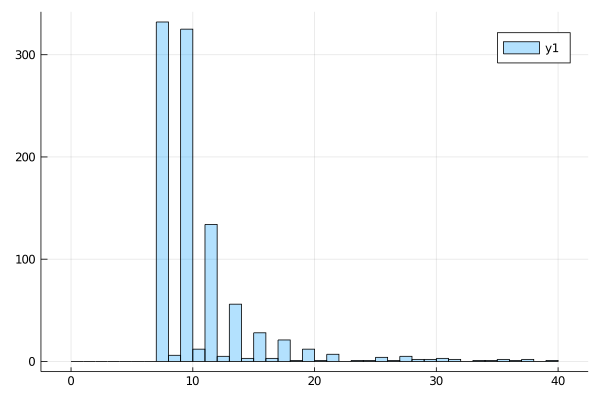

In [6]:
game0 = GameGridWorldBase(dims, allowed_movements_all["cross"])
ruleset = GridWorld2d.RulesetNonWindy(game0, pos_start, pos_goal)
game = GridWorld2d.GameGridWorld(game0, ruleset)

ε = 0.1
player = PlayerεGreedy(game, ε)

α = 0.5
γ = 1.0
learning = LearningSarsa(player, α, γ)

max_nsteps = 1000
ngames = 1000
results = [play_game(game, player, max_nsteps, learning)[1] for _ in 1:ngames]
histogram(results, bins=0:1:40, fillalpha=0.3)

```julia
# 1e6 games -> 0.5s
function f(game, player, max_nsteps, learning, ngames)
    [play_game(game, player, max_nsteps, learning) for _ in 1:ngames]
end

f(game, player, max_nsteps, learning, 1)

@time f(game, player, max_nsteps, learning, 1000000);
```

#### Let's add some wind

In [7]:
module GridWorldWindy2d

import ReinforcementLearningSutton.Commons: actions, finished, restart, state, update
using ReinforcementLearningSutton.Commons: I2, T2, state_set, tuple2index
using ReinforcementLearningSutton.GridWorld: GameGridWorldBase, GameGridWorld, dims

struct RulesetWindConstant
    state_start::I2
    state_goal::I2
    field::Array{T2, 2}
    
    function RulesetWindConstant(game0::GameGridWorldBase, pos_start::T2, pos_goal::T2, field::Array{T2, 2})
        new(state(game0, pos_start), state(game0, pos_goal), field)
    end
end

function wind(w::RulesetWindConstant, p::T2)
    w.field[p[2], p[1]]
end

struct RulesetWindStochastic
    state_start::I2
    state_goal::I2
    field::Array{T2, 2}
    deltas::Vector{T2}
    
    function RulesetWindStochastic(game0::GameGridWorldBase, pos_start::T2, pos_goal::T2, field::Array{T2, 2}, deltas::Vector{T2})
        new(state(game0, pos_start), state(game0, pos_goal), field, deltas)
    end
end

function wind(w::RulesetWindStochastic, p::T2)
    w.field[p[2], p[1]] .+ rand(w.deltas)
end

const GameType = Union{GameGridWorld{GameGridWorldBase{T2, T2}, RulesetWindConstant},
                       GameGridWorld{GameGridWorldBase{T2, T2}, RulesetWindStochastic}}

actions(game::GameType, state::I2) = game.game0.actions
finished(game::GameType) = (state(game) == game.ruleset.state_goal)
restart(game::GameType) = state_set(game, game.ruleset.state_start)

function update(game::GameType, action::I2)::Int
    s0 = state(game)
    w = wind(game.ruleset, s0.value)
    
    pos_x = max(1, min(s0.value[1] + w[1] + action.value[1], dims(game)[1]))
    pos_y = max(1, min(s0.value[2] + w[2] + action.value[2], dims(game)[2]))
    s = state(game, (pos_x, pos_y))
    state_set(game, s)
    -1
end

end;

##### Constant wind

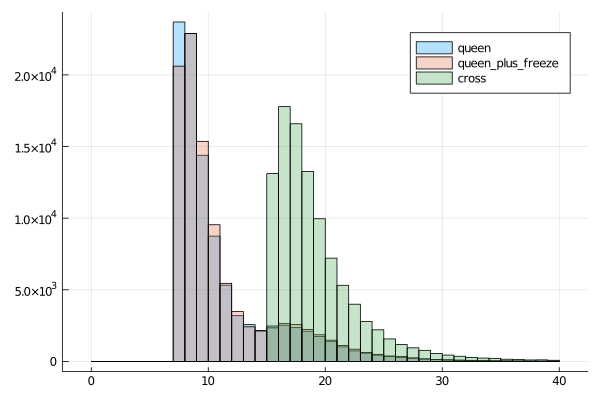

In [8]:
ε = 0.1
α = 0.5
γ = 1.0

max_nsteps = 1000
ngames = 100000
results = zeros(Int, ngames, length(allowed_movements_all))
for (i, lbl) in enumerate(keys(allowed_movements_all))
    game0 = GameGridWorldBase(dims, allowed_movements_all[lbl])
    ruleset = GridWorldWindy2d.RulesetWindConstant(game0, pos_start, pos_goal, wind_field)
    game = GridWorld2d.GameGridWorld(game0, ruleset)
    
    player = PlayerεGreedy(game, ε)
    learning = LearningSarsa(player, α, γ)

    results[:, i] = [play_game(game, player, max_nsteps, learning)[1] for _ in 1:ngames]
end

histogram(results, bins=0:1:40, fillalpha=0.3, label=reshape(collect(keys(allowed_movements_all)), 1, :))

In [9]:
median(results[900:end, :], dims=1)

1×3 Array{Float64,2}:
 9.0  9.0  18.0

##### Stochastic wind

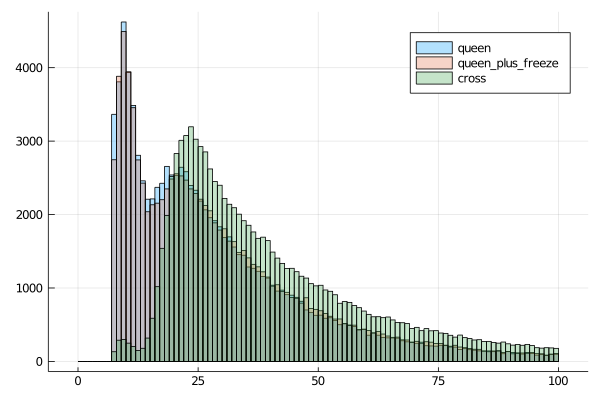

In [10]:
ε = 0.1
α = 0.5
γ = 1.0

max_nsteps = 1000
ngames = 100000
results = zeros(Int, ngames, length(allowed_movements_all))
for (i, lbl) in enumerate(keys(allowed_movements_all))
    game0 = GameGridWorldBase(dims, allowed_movements_all[lbl])
    ruleset = GridWorldWindy2d.RulesetWindStochastic(game0, pos_start, pos_goal, wind_field, [(0, -1), (0, 0), (0, 1)])
    game = GridWorld2d.GameGridWorld(game0, ruleset)
    
    player = PlayerεGreedy(game, ε)
    learning = LearningSarsa(player, α, γ)

    results[:, i] = [play_game(game, player, max_nsteps, learning)[1] for _ in 1:ngames]
end

histogram(results, bins=0:1:100, fillalpha=0.3, label=reshape(collect(keys(allowed_movements_all)), 1, :))

In [11]:
median(results[900:end, :], dims=1)

1×3 Array{Float64,2}:
 24.0  25.0  35.0